## **📌 Step 1: Problem Statement**

**This project is about building a smart system that can work with a collection of Medium articles.**

**The main objective is to understand what each article is about, group similar articles together, suggest the right tags for them, and figure out which articles might get more attention. This involves analyzing the article content, identifying key patterns in how they are written and tagged, and using that information to make intelligent recommendations.**

## **📌 Step 2: Importing the Necessary Libraries**

In [5]:
# Basic libraries for data manipulation
import pandas as pd
import numpy as np
import ast

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# For Text Preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Ignore warnings for better readability
import warnings
warnings.filterwarnings('ignore')

# Set a visual style
sns.set_style("whitegrid")

## **📌 Step 3: Loading the Dataset**

In [6]:
file_path = "/kaggle/input/medium-article-dataset/AI-Powered Content Analysis and Recommendation.csv"

# Load the dataset
df = pd.read_csv(file_path)

# Preview of the data
df.head() 

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,['Ryan Fan'],2020-12-26 03:38:10.479000+00:00,"['Mental Health', 'Health', 'Psychology', 'Sci..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,['Simon Spichak'],2020-09-23 22:10:17.126000+00:00,"['Mental Health', 'Coronavirus', 'Science', 'P..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[],2020-10-10 20:17:37.132000+00:00,"['Biotechnology', 'Neuroscience', 'Brain', 'We..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,['Eshan Samaranayake'],2020-12-21 16:05:19.524000+00:00,"['Health', 'Neuroscience', 'Mental Health', 'P..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,['Rishav Sinha'],2020-02-26 00:01:01.576000+00:00,"['Brain', 'Health', 'Development', 'Psychology..."


*The dataset consists of six features: title, text, URLs, authors, timestamp, and tags. The 'authors' and 'tags' columns are in list format, while the remaining columns are in text format. This is a well-structured dataset suitable for achieving the goals of this project*

## **📌 Step 4: Exploring the Data**

In [7]:
# No of rows & columns
df.shape

(192368, 6)

*The dataset consists of 19,236 rows and 6 columns. Using info(), we can observe the count of non-null values in each column along with their data types*

In [8]:
# Get basic information about the data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192368 entries, 0 to 192367
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   title      192363 non-null  object
 1   text       192368 non-null  object
 2   url        192368 non-null  object
 3   authors    192368 non-null  object
 4   timestamp  192366 non-null  object
 5   tags       192368 non-null  object
dtypes: object(6)
memory usage: 8.8+ MB


*The describe() function provides information such as the number of entries, unique values, the most frequent value, and its frequency.*

In [9]:
# Summary of the data
df.describe()

,title,text,url,authors,timestamp,tags
count,192363,192368,192368,192368,192366,192368
unique,187892,185474,192368,83915,191612,183380
top,by Martino Pietropoli,Learn more. Medium is an open platform where 1...,https://medium.com/invisible-illness/mental-no...,[],2019-03-13 14:21:44.055000+00:00,['Startup']
freq,93,1976,1,30955,22,80


**From the output, we can infer that the 'authors' column often contains empty lists, indicating missing author names for many articles. Also, each URL appears only once, confirming that all URLs are unique.**

## **📌 Step 5: Datatype Conversion**

In [10]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')

# Convert authors & tags from String to List
df['authors'] = df['authors'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

df['tags'] = df['tags'].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

*The data type of the 'timestamp' column is converted to datetime format to enable time-based analysis. The 'authors' and 'tags' columns are converted from string to list format for future use in tag modeling and author analysis.*

## **📌 Step 6: Cleaning the Data**

*Used isnull() to identify missing values in the dataset.*

In [11]:
# Check for nulls
df.isnull().sum()

title          5
text           0
url            0
authors        0
timestamp    413
tags           0
dtype: int64

**From the output, only the 'title' and 'timestamp' columns have missing values, with counts of 5 and 413 respectively. These will be handled by removing the corresponding rows from the dataset.**

**Since these columns are important for future analysis, imputing them may not be reliable. Additionally, the number of missing rows is less than 1% of the dataset, so their removal will not significantly impact the data.**

In [12]:
# Drop rows with missing title, text or timestamp
df = df.dropna(subset=['title', 'text','timestamp'])

*Identify empty entries in the 'authors' and 'tags' columns and replace them with "Unknown" and "Untagged" respectively*

In [13]:
# Count empty lists in authors
empty_authors_count = df['authors'].apply(lambda x: len(x) == 0).sum()

# Count empty lists in tags
empty_tags_count = df['tags'].apply(lambda x: len(x) == 0).sum()

print(f"Empty lists in 'authors': {empty_authors_count}")
print(f"Empty lists in 'tags': {empty_tags_count}")

Empty lists in 'authors': 30858
Empty lists in 'tags': 0


In [14]:
# Replace empty authors with Unknown and empty tags with Untagged
df['authors'] = df['authors'].apply(lambda x: ["Unknown"] if not x else x)

df['tags'] = df['tags'].apply(lambda x: ["Untagged"] if not x else x)

*Visualizing part of data before cleaning*

In [15]:
df.head()

,title,text,url,authors,timestamp,tags
0,Mental Note Vol. 24,Photo by Josh Riemer on Unsplash\n\nMerry Chri...,https://medium.com/invisible-illness/mental-no...,[Ryan Fan],2020-12-26 03:38:10.479000+00:00,"[Mental Health, Health, Psychology, Science, N..."
1,Your Brain On Coronavirus,Your Brain On Coronavirus\n\nA guide to the cu...,https://medium.com/age-of-awareness/how-the-pa...,[Simon Spichak],2020-09-23 22:10:17.126000+00:00,"[Mental Health, Coronavirus, Science, Psycholo..."
2,Mind Your Nose,Mind Your Nose\n\nHow smell training can chang...,https://medium.com/neodotlife/mind-your-nose-f...,[Unknown],2020-10-10 20:17:37.132000+00:00,"[Biotechnology, Neuroscience, Brain, Wellness,..."
3,The 4 Purposes of Dreams,Passionate about the synergy between science a...,https://medium.com/science-for-real/the-4-purp...,[Eshan Samaranayake],2020-12-21 16:05:19.524000+00:00,"[Health, Neuroscience, Mental Health, Psycholo..."
4,Surviving a Rod Through the Head,"You’ve heard of him, haven’t you? Phineas Gage...",https://medium.com/live-your-life-on-purpose/s...,[Rishav Sinha],2020-02-26 00:01:01.576000+00:00,"[Brain, Health, Development, Psychology, Science]"


*We used the clean_text function to clean the data by converting it to lowercase, removing special characters, extra whitespace, and URLs.*

In [16]:
# Function to clean text
def clean_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply basic cleaning to title and text
df['clean_title'] = df['title'].apply(clean_text)
df['clean_text'] = df['text'].apply(clean_text)

## **📌 Step 7: Data Preprocessing Text Data**

In [17]:
# !unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

*The next step is to preprocess the text data by applying tokenization, lemmatization, and removing stop words to prepare it for further analysis and modeling.*

* Tokenization: Breaking text into individual words or terms.
Example: "AI is powerful" → ["AI", "is", "powerful"]

* Lemmatization: Reducing words to their base or dictionary form.
Example: "running", "ran", "runs" → "run"

* Stop Words: Commonly used words that are often removed in NLP tasks.
Example: "is", "the", "and", "in"

In [18]:
# Function for tokenization and lemmatization
def tokenize_and_lemmatize(text):
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords and lemmatize
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    
    return tokens

# Apply tokenization and lemmatization
df['tokenized_title'] = df['clean_title'].apply(tokenize_and_lemmatize)
df['tokenized_text'] = df['clean_text'].apply(tokenize_and_lemmatize)

## **📌 Step 8: Exploratory Data Analysis** (EDA)

*Start with, Word count/text length analysis*

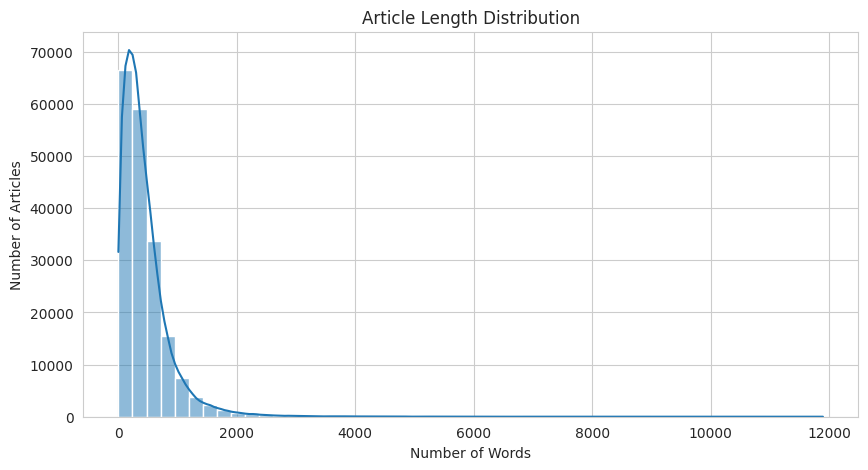

In [19]:
# Length by word count
df['article_length'] = df['tokenized_text'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['article_length'], bins=50, kde=True)
plt.title('Article Length Distribution')
plt.xlabel('Number of Words')
plt.ylabel('Number of Articles')
plt.show()

**✅Insight: Most articles are under 1,000 words, with all articles being below ~2,500 words. The distribution peaks on the left, indicating that shorter articles are more common than longer ones**

*Identify and display the most common tags (top 20)*

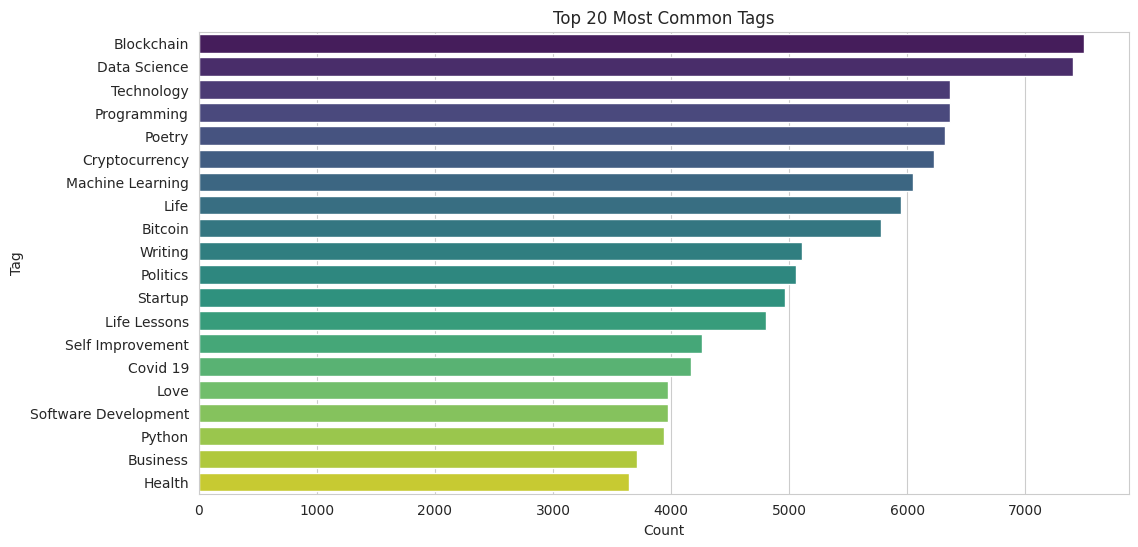

In [20]:
from collections import Counter

# Flatten list of all tags
all_tags = [tag for tags in df['tags'] for tag in tags]
tag_counts = Counter(all_tags)

# Convert to DataFrame
top_n = 20
tag_df = pd.DataFrame(tag_counts.most_common(top_n), columns=['Tag', 'Count'])

plt.figure(figsize=(12, 6))
sns.barplot(data=tag_df, x='Count', y='Tag', palette='viridis')
plt.title(f'Top {top_n} Most Common Tags')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.show()

**✅Insight: Blockchain, Data Science, and Technology are the most common tags in the dataset, indicating that a majority of the articles are related to tech content.**

*Identifying tag count per article*

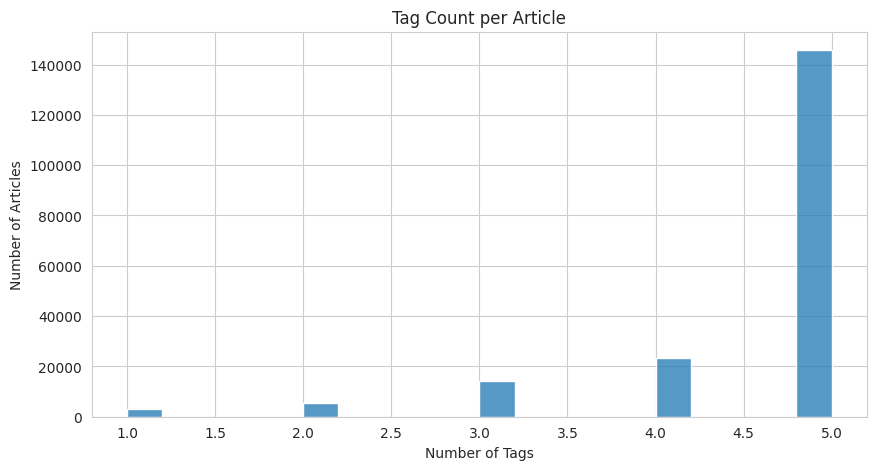

In [21]:
df['num_tags'] = df['tags'].apply(len)

plt.figure(figsize=(10, 5))
sns.histplot(df['num_tags'], bins=20, kde=False)
plt.title('Tag Count per Article')
plt.xlabel('Number of Tags')
plt.ylabel('Number of Articles')
plt.show()

**✅Insight: The majority of articles have 5 tags, and the article count decreases with fewer tags. This suggests that authors commonly use 5 tags, which can be useful for building a tag recommendation system**

*Identify and display top 20 authors with most articles*

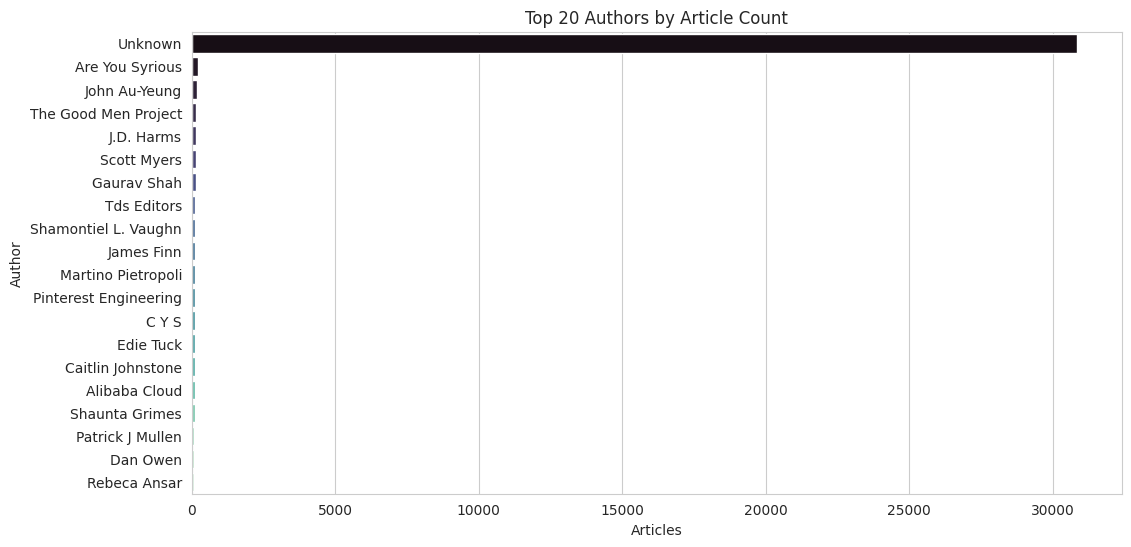

In [25]:
# Flatten list of authors
all_authors = [author for authors in df['authors'] for author in authors]
author_counts = Counter(all_authors)

# DataFrame for top authors
top_n = 20
author_df = pd.DataFrame(author_counts.most_common(top_n), columns=['Author', 'Articles'])

plt.figure(figsize=(12, 6))
sns.barplot(data=author_df, x='Articles', y='Author', palette='mako')
plt.title(f'Top {top_n} Authors by Article Count')
plt.xlabel('Articles')
plt.ylabel('Author')
plt.show()

**✅ Insight: As observed earlier, the count of empty lists in the 'authors' column is high. This is reflected here as well, where "Unknown" authors appear most frequently, while all other authors have significantly lower counts**

*Identify articles published in different days of the week*

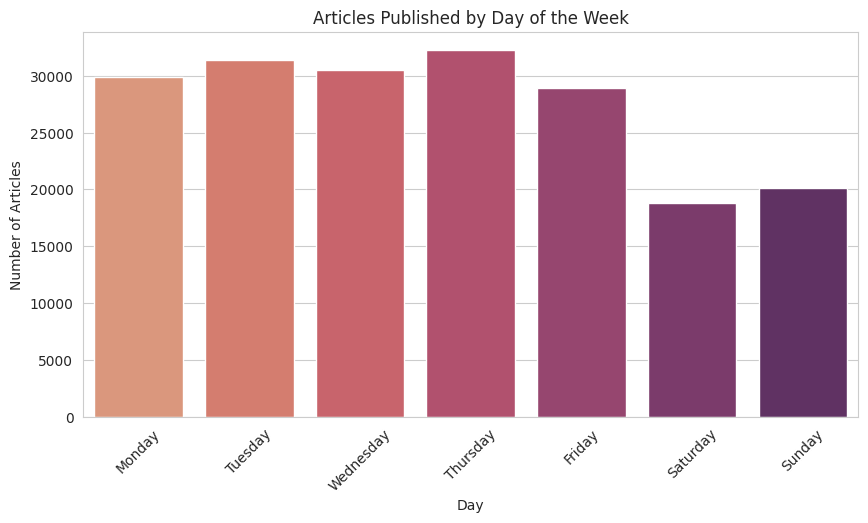

In [23]:
df['weekday'] = df['timestamp'].dt.day_name()

plt.figure(figsize=(10, 5))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='weekday', data=df, order=order, palette='flare')
plt.title('Articles Published by Day of the Week')
plt.xlabel('Day')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.show()

**✅ Insight: Most articles are published at the start of the week, indicating that authors are more active in posting articles during that time**